In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from piston_1 import DMDPiston
from waveoptics.plots.plots import complex_imshow
from dmdholo.fields_propagation.fourier_filter import fourier_filter
from dmdholo.holograms.dmd_holograms import parallel_lee,  orthogonal_lee, holo_SP, holo_Haskell, holo_SP_optimized, holo_SP_optimized_cupy, holo_SP_super_optimized, debug_holo_comparison
from dmdholo.holograms.generate_LUT import generate_lut
from dmdholo.plotting.plot_funs import colorize
import time

# LUT Calculation 

## Px=4

In [2]:
px = 4
nuvec = np.array((1/px,1/px**2)) 
SA_filter = 1.0*np.linalg.norm(nuvec)/6
f_val, px_comb, lut = generate_lut('sp', px)

# HOLO (Actuators) 

## Generation 

SP time: 0.48842334747314453
Opt SP time: 0.043950796127319336
Opt SP time cupy: 0.899925947189331
SOpt SP time: 0.010008573532104492


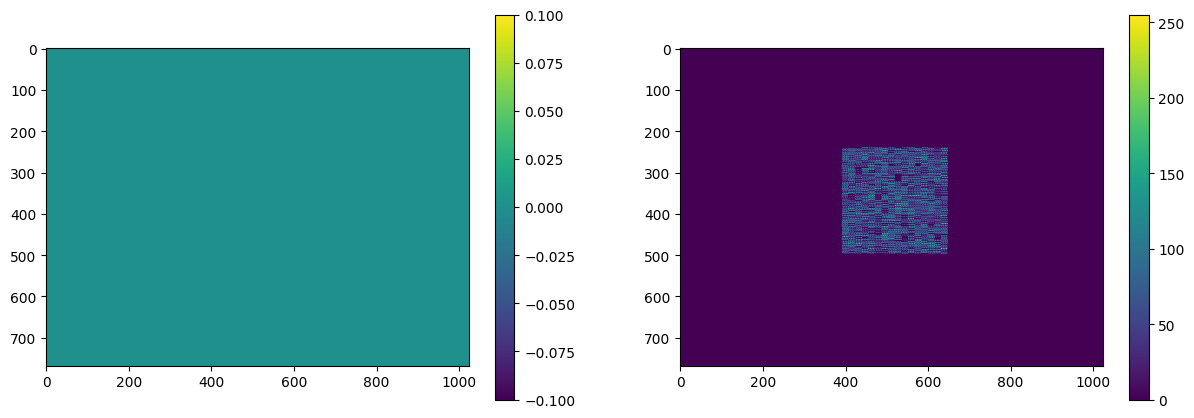

In [6]:
import cupy as cp

DMD_nSizeY=768
DMD_nSizeX=1024
n_actu_1D = 16
roi_size=256
# Initialisation du DMD avec une région d'intérêt (ROI)
dmd = DMDPiston(n_actu_1D, roi_size=roi_size, roi_shifts=(370, 520))  # H,V (400,520)

# Génération d'hologrammes
nbr_holos = 1
Holos_Actu = []
maps=[]
generated_fields = set()
for i in range(nbr_holos):  # Correction de `np.(nbr_holos)` en `range(nbr_holos)`
    dmd.generate_fields(n_actu_1D, rand_amp=True, rand_phi=True,phi_clx=None,phi=None)
    target_field = np.copy(dmd.field_matrix)


    target_field /= np.max(np.abs(target_field))

    # Conversion en hologramme
    t0 = time.time()
    holo_sp = holo_SP(target_field, lut, px_comb).astype(np.uint8)
    time_sp = time.time() - t0

    t0 = time.time()
    holo_sp_opt = holo_SP_optimized(target_field, lut, px_comb).astype(np.uint8)
    time_sp_opt = time.time() - t0

    t0 = time.time()
    holo_sp_opt_cupy = holo_SP_optimized_cupy(cp.asarray(target_field), cp.asarray(lut), cp.asarray(px_comb)).astype(np.uint8)
    time_sp_opt_cupy = time.time() - t0

    # print(np.allclose(holo_SP(target_field, lut, px_comb), holo_SP_super_optimized(target_field, lut, px_comb)))
    # print(np.all(holo_SP(target_field, lut, px_comb) == holo_SP_super_optimized(target_field, lut, px_comb)))

    # orig_indices = holo_SP(target_field, lut, px_comb)
    # sopt_indices = holo_SP_super_optimized(target_field, lut, px_comb)
    # print(f"Max difference: {np.max(np.abs(orig_indices - sopt_indices))}")
    # plt.imshow(orig_indices - sopt_indices, cmap="seismic", interpolation="nearest")
    # plt.colorbar()
    # plt.show()

    # orig_shifts = np.mod(n_SP * np.arange(sh[0]), n_SP**2)[:, None]
    # sopt_shifts = np.mod(n_SP * np.arange(sh[0]), n_SP**2)[:, None]
    # print("Shifts match:", np.all(orig_shifts == sopt_shifts))

    t0 = time.time()
    holo_sp_sopt = holo_SP_super_optimized(target_field, lut, px_comb).astype(np.uint8)
    time_sp_sopt = time.time() - t0
    
    holo_sp=holo_sp*(2**8-1)
    holo_sp_opt=holo_sp_opt*(2**8-1)
    holo_sp_sopt=holo_sp_sopt*(2**8-1)


print(f"SP time: {time_sp}\nOpt SP time: {time_sp_opt}\nOpt SP time cupy: {time_sp_opt_cupy}\nSOpt SP time: {time_sp_sopt}")

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.imshow(holo_sp_opt - holo_sp)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(holo_sp_sopt - holo_sp)
plt.colorbar()


## Saving the holos in a folder 